#### Diabetes in Embedding Space

Investigate Embeddings of Diabetes data on Sequence and Patient level

In [1]:
cd ..

/home/ubuntu/CVC


In [2]:
import transformers
import scanpy
import scipy

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os, sys
import collections
import numpy as np
import pandas as pd
import torch
from torch_geometric.loader import DataLoader
import pickle

SRC_DIR = "cvc"
sys.path.append(SRC_DIR)
from child_diabetes_timepoints import diabetes_utils as du
from child_diabetes_timepoints import graph_classifiers as gc
from cvc import embbeding_wrapper as ew
from child_diabetes_timepoints import graph_utils as gu
from child_diabetes_timepoints import graph_GRAPE_utils as ggu
from cvc import utils
from lab_notebooks.utils import TRANSFORMER, DATA_DIR, DEVICE
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
from tqdm import tqdm

2023-09-07 10:29:34.942658: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-07 10:29:34.944427: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 10:29:34.981822: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 10:29:34.982524: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 10:29:35.604916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [5]:
# use gpu 1
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=1)

#### Load and Process data

In [6]:
DATA_FOLDER_DIR = "/home/ubuntu/CVC/data/diabetes/"
CACHE_DIR = "cache/diabetes/"

if not os.path.isdir(CACHE_DIR):
    os.makedirs(CACHE_DIR)

In [7]:
# combine files according to control/case metadata
case_samples_dir = DATA_FOLDER_DIR + "case_samples.csv"
control_samples_dir = DATA_FOLDER_DIR + "control_samples.csv"

In [8]:
# data flag to indicate if we need to parse the tags
NEW_DATA = 0

In [9]:
# read the case_samples_dir and control_samples_dir with pandas
case_df = pd.read_csv(case_samples_dir)
control_df = pd.read_csv(control_samples_dir)

/tmp/ipykernel_653851/406716203.py:2: DtypeWarning: Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  case_df = pd.read_csv(case_samples_dir)


In [17]:
NEW_DATA = 1

In [18]:
if NEW_DATA == 1:
    # Process metadata
    case_samples = du.process_diabetes_metadata(case_samples_dir)
    #take out index 12 from case_samples
    case_samples = case_samples.drop(12)
    control_samples = du.process_diabetes_metadata(control_samples_dir)

    print("Join data for each patient")
    # Join data for each patient
    cases_dataframes_dict = du.join_data(case_samples, DATA_FOLDER_DIR)
    control_dataframes_dict = du.join_data(control_samples, DATA_FOLDER_DIR)

    cases_dataframes_dict = du.apply_parse_tags(cases_dataframes_dict)
    control_dataframes_dict = du.apply_parse_tags(control_dataframes_dict)

    # pickle the dataframes dict
    with open(CACHE_DIR + 'cases_dataframes_dict_new.pickle', 'wb') as handle:
        pickle.dump(cases_dataframes_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(CACHE_DIR + 'control_dataframes_dict_new.pickle', 'wb') as handle:
        pickle.dump(control_dataframes_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    # read the pickled dataframes dict
    with open(CACHE_DIR + 'cases_dataframes_dict_new.pickle', 'rb') as handle:
        cases_dataframes_dict = pickle.load(handle)
    with open(CACHE_DIR + 'control_dataframes_dict_new.pickle', 'rb') as handle:
        control_dataframes_dict = pickle.load(handle)

/home/ubuntu/CVC/child_diabetes_timepoints/diabetes_utils.py:11: DtypeWarning: Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  samples = pd.read_csv(directory)


Join data for each patient


/home/ubuntu/CVC/child_diabetes_timepoints/diabetes_utils.py:43: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_file = pd.read_csv(file_path, sep='\t', usecols=column_to_use)
/home/ubuntu/CVC/child_diabetes_timepoints/diabetes_utils.py:43: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_file = pd.read_csv(file_path, sep='\t', usecols=column_to_use)
/home/ubuntu/CVC/child_diabetes_timepoints/diabetes_utils.py:43: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_file = pd.read_csv(file_path, sep='\t', usecols=column_to_use)
/home/ubuntu/CVC/child_diabetes_timepoints/diabetes_utils.py:43: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_file = pd.read_csv(file_path, sep='\t', usecols=column_to_use)
/home/ubuntu/CVC/child_diabetes_timepoints/diabetes_utils.py:43:

#### Create and Display embeddings

In [19]:
from cvc.embbeding_wrapper import EmbeddingWrapper
def create_sample_embeddings(patient_data, TRANSFORMER, DEVICE, batch_size=1024, method="mean", layers=[-1]):
    patient_embeddings_list = []
    for patient_sample_data in patient_data:
        embed_wrap = EmbeddingWrapper(TRANSFORMER, DEVICE, patient_sample_data, batch_size=batch_size, method=method, layers=layers)
        patient_embeddings_list.append(embed_wrap)
    return patient_embeddings_list

In [20]:
def create_all_patient_embeddings(cases_dataframes_dict, TRANSFORMER, DEVICE, batch_size=1024, method="mean", layers=[-1]):
    patient_embeddings_dict = {}
    for key in cases_dataframes_dict.keys():
        patient_embeddings_dict[key] = create_sample_embeddings(cases_dataframes_dict[key], TRANSFORMER, DEVICE, batch_size, method, layers)
    return patient_embeddings_dict

In [ ]:
if NEW_DATA == 1:
    case_patient_embeddings_dict = create_all_patient_embeddings(cases_dataframes_dict, TRANSFORMER, DEVICE)
    control_patient_embeddings_dict = create_all_patient_embeddings(control_dataframes_dict, TRANSFORMER, DEVICE)
    # export the embeddings
    with open(CACHE_DIR + 'case_patient_embeddings_dict_new.pickle', 'wb') as handle:
        pickle.dump(case_patient_embeddings_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(CACHE_DIR + 'control_patient_embeddings_dict_new.pickle', 'wb') as handle:
        pickle.dump(control_patient_embeddings_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    pass
    # with open(CACHE_DIR + 'case_patient_embeddings_dict.pickle', 'rb') as handle:
    #     case_patient_embeddings_dict = pickle.load(handle)
    # with open(CACHE_DIR + 'control_patient_embeddings_dict.pickle', 'rb') as handle:
    #     control_patient_embeddings_dict = pickle.load(handle)

Some weights of the model checkpoint at /home/ubuntu/CVC/output_5mil_even_priv_pub were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/81 [00:00<?, ?it/s]

Some weights of the model checkpoint at /home/ubuntu/CVC/output_5mil_even_priv_pub were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/92 [00:00<?, ?it/s]

In [15]:
if NEW_DATA == 1:
    # the 3rd timepoint (2) of patient 26 is too small
    case_patient_embeddings_dict_no26 = case_patient_embeddings_dict.copy()
    case_patient_embeddings_dict_no26.pop(26)
    cases_dataframes_dict_no26 = cases_dataframes_dict.copy()
    cases_dataframes_dict_no26.pop(26)

    case_CVC_graph_dict = ggu.create_cvc_graph_dict(case_patient_embeddings_dict_no26, cases_dataframes_dict_no26, 'case')
    control_CVC_graph_dict = ggu.create_cvc_graph_dict(control_patient_embeddings_dict, control_dataframes_dict, 'control')
    # export the embeddings
    with open(CACHE_DIR + 'case_CVC_graph_dict.pickle', 'wb') as handle:
        pickle.dump(case_CVC_graph_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(CACHE_DIR + 'control_CVC_graph_dict.pickle', 'wb') as handle:
        pickle.dump(control_CVC_graph_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(CACHE_DIR + 'case_CVC_graph_dict.pickle', 'rb') as handle:
        case_CVC_graph_dict = pickle.load(handle)
    with open(CACHE_DIR + 'control_CVC_graph_dict.pickle', 'rb') as handle:
        control_CVC_graph_dict = pickle.load(handle)

ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

##### Extract Embeddings from Graphs

In [ ]:
len(cases_dataframes_dict)

In [ ]:
def extract_embeddings(data_dict):
    # Initialize a dictionary to hold the extracted embeddings
    extracted_embeddings = {}
    # Iterate through the keys of the data_dict
    for key in data_dict:
        # Extract the embeddings for each key and store in the new dictionary
        extracted_embeddings[key] = data_dict[key]['embeddings']
    return extracted_embeddings

In [ ]:
case_patient_timepoint_embeddings = extract_embeddings(case_CVC_graph_dict)
control_patient_timepoint_embeddings = extract_embeddings(control_CVC_graph_dict)

In [ ]:
len(case_patient_timepoint_embeddings), len(control_patient_timepoint_embeddings)

In [ ]:
cases_dataframes_dict.pop(26)
len(cases_dataframes_dict), len(control_dataframes_dict)

In [ ]:
cases_dataframes_dict_updated = du.create_patient_timepoint_dict(cases_dataframes_dict)
control_dataframes_dict_updated = du.create_patient_timepoint_dict(control_dataframes_dict)
len(cases_dataframes_dict_updated), len(control_dataframes_dict_updated)

In [ ]:
# export the embeddings of the 3rd timepoint
cases_timepoint_3_embeddings = du.filter_by_timepoint(case_patient_timepoint_embeddings, 3)
control_timepoint_3_embeddings = du.filter_by_timepoint(control_patient_timepoint_embeddings, 3)

In [ ]:
cases_timepoint_3_embeddings['0_3']

In [ ]:
concatenated_labeled_embeddings_tp3 = du.concatenate_and_label(cases_timepoint_3_embeddings, control_timepoint_3_embeddings)

In [ ]:
concatenated_labeled_embeddings_tp3

In [51]:
collections.Counter(concatenated_labeled_embeddings_tp3['label'])

TypeError: cast_scalar_indexer() got an unexpected keyword argument 'warn_float'

In [46]:
final_df = concatenated_labeled_embeddings_tp3

In [ ]:
# Shuffle the data and take a subset
grouped = final_df.groupby('label')
sampled = grouped.apply(lambda x: x.sample(frac=0.5))

# Separate features and labels
X_sample = sampled.drop('label', axis=1)
y_sample = sampled['label']

In [ ]:
import atom
from atom import dataframe_utils

# Load data
X = X_sample
y = y_sample

# Configure Atom
config = atom.AppConfig(project_id='EmbeddingsBenchmark')
config.select_task(task_type='classification')

# Create Atom experiment
experiment = atom.Experiment(config)

# Add data, metric, time constraint
experiment.add_data(X, y)
experiment.add_metric('accuracy')
experiment.set_max_runtime(120) # 2 hours

# Run experiment
results = experiment.run()

# Get best pipeline
best_pipeline = results.get_best_pipeline()

X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=123)

# Evaluate on test set
X_test, y_test = load_test_data()
y_pred = best_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

#### Display embeddings

##### Prepare data for visualization

In [66]:
len(control_dataframes_dict), len(control_patient_timepoint_embeddings)

(25, 100)

In [69]:
import pandas as pd
import numpy as np

def prepare_patient_data(patient_id, dataframes_dict, embeddings_dict):
    """
    Prepare the concatenated dataframe and embeddings for a specific patient.
    Parameters:
    - patient_id (str): The ID of the patient to prepare data for.
    - dataframes_dict (dict): Dictionary containing dataframes for each patient and timepoint.
    - embeddings_dict (dict): Dictionary containing embeddings for each patient and timepoint.
    Returns:
    - Tuple: (Concatenated dataframe, concatenated embeddings, timepoint labels)
    """
    patient_dfs_list = []
    patient_embeddings_list = []
    timepoint_labels = []

    for key in sorted(dataframes_dict.keys()):  # Sorting ensures consistent order
        if key.startswith(f"{patient_id}_"):
            patient_dfs_list.append(dataframes_dict[key])
            patient_embeddings_list.append(embeddings_dict[key])
            timepoint_labels.extend([key] * len(dataframes_dict[key]))

    all_patient_df = pd.concat(patient_dfs_list, ignore_index=True)
    all_patient_embeddings = np.concatenate(patient_embeddings_list, axis=0)

    all_patient_df['timepoint'] = timepoint_labels

    return all_patient_df, all_patient_embeddings, timepoint_labels

In [75]:
patient_id = "1"

# Case
case_all_patient_0_df, case_all_patient_0_embeddings, case_timepoint_labels = prepare_patient_data(
    patient_id,
    cases_dataframes_dict_updated,  # Replace with your actual dict
    case_patient_timepoint_embeddings  # Replace with your actual dict
)
# Control
control_all_patient_0_df, control_all_patient_0_embeddings, control_timepoint_labels = prepare_patient_data(
    patient_id,
    control_dataframes_dict_updated,  # Replace with your actual dict
    control_patient_timepoint_embeddings  # Replace with your actual dict
)

##### Plotting

In [72]:
def plot_patient_embeddings(sequences_df, embeddings, color_map, patient_type, patient_id):
    # Initialize the EmbeddingWrapper
    embedding_wrapper = EmbeddingWrapper(
        model=None,  # No need for a model if embeddings are already available
        device=None,  # Likewise, no need for a device
        sequences_df=sequences_df,
        embeddings=embeddings  # Pass your concatenated embeddings here
    )

    # Explicitly set the embeddings attribute
    embedding_wrapper.embeddings = embeddings

    # Now, you can use the `plot_embedding` method
    embedding_wrapper.plot_embedding(
        color_embed='timepoint',
        color_map=color_map,
        title=f'{patient_type} Patient {patient_id} Embeddings by Timepoint'
    )

In [ ]:
# Define a color map
from matplotlib.colors import ListedColormap
import seaborn as sns
my_color_map = ListedColormap(sns.color_palette("Spectral", 4))

/home/ubuntu/miniconda3/envs/cvc/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ubuntu/miniconda3/envs/cvc/lib/python3.8/site-packages/umap/spectral.py:255: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/ubuntu/miniconda3/envs/cvc/lib/python3.8/site-packages/umap/spectral.py:255: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


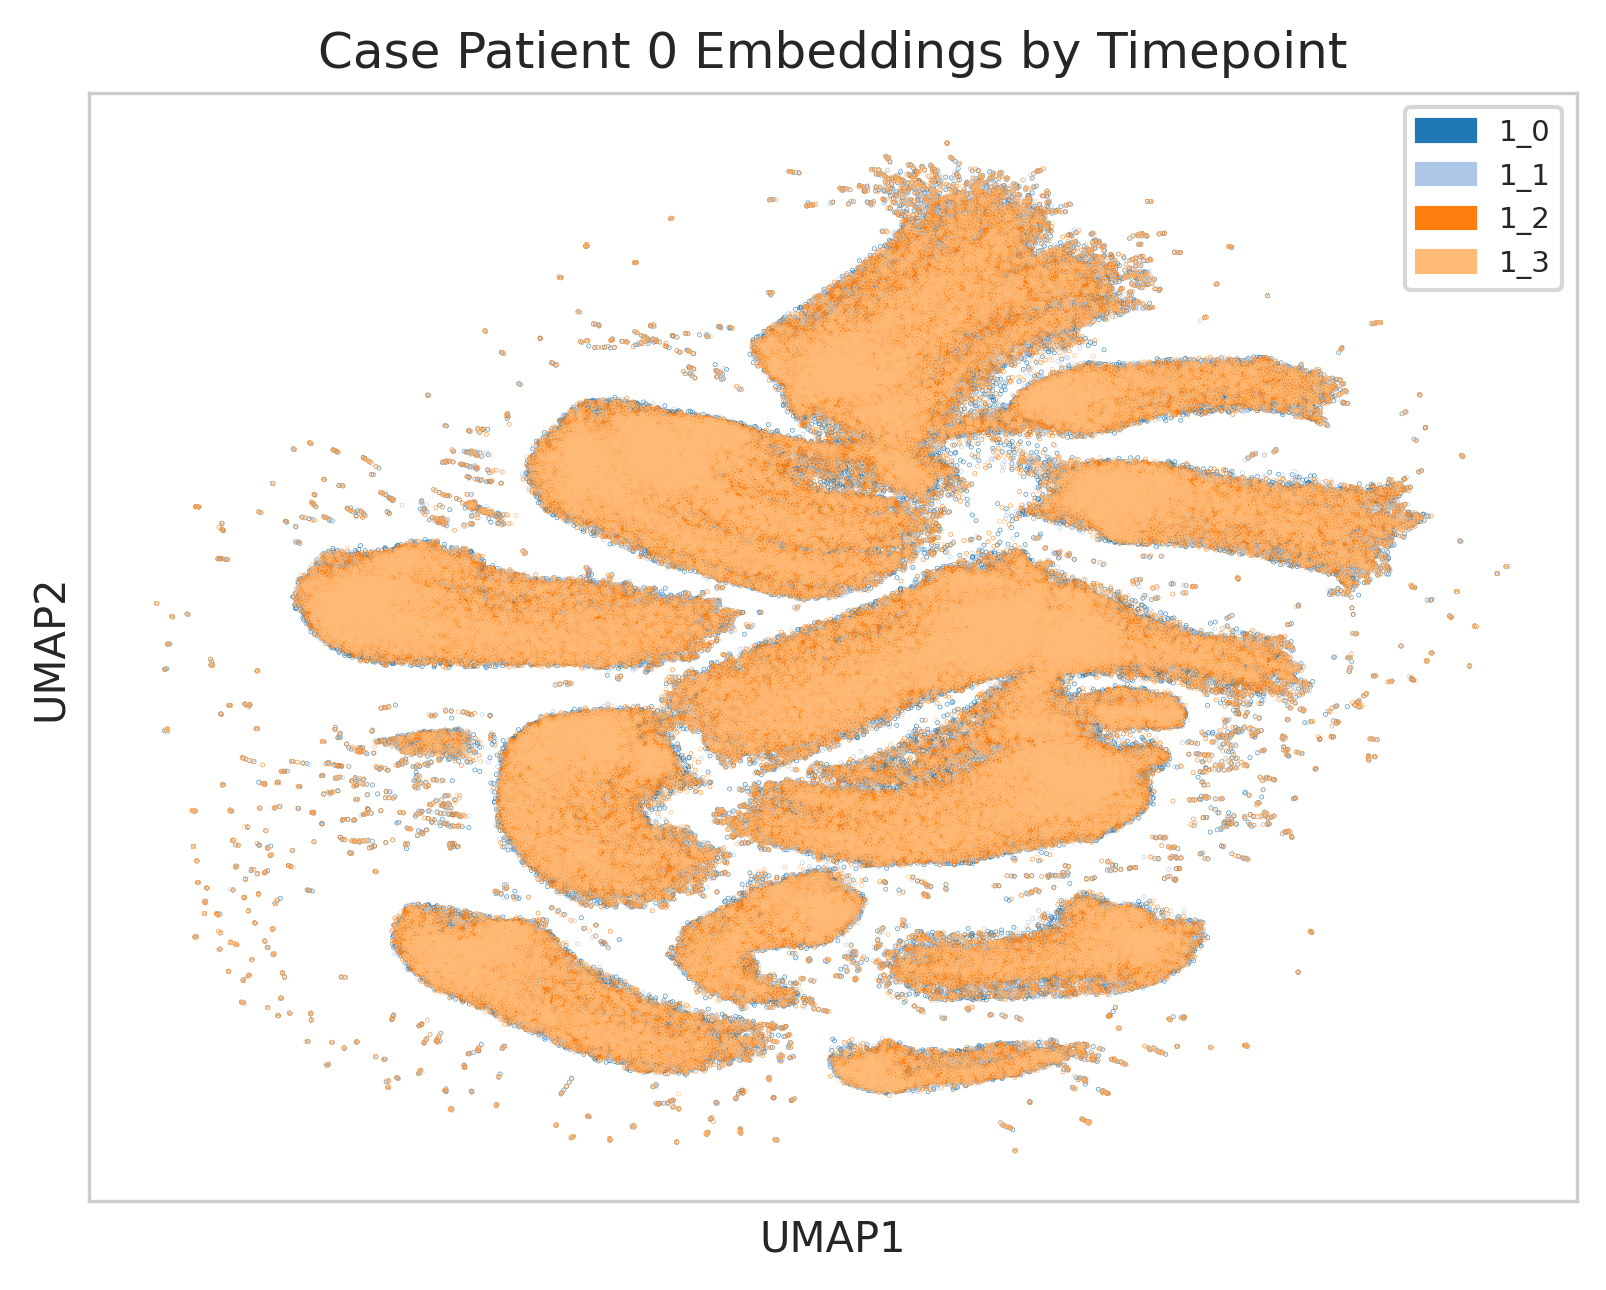

In [73]:
# Case
plot_patient_embeddings(
    sequences_df=case_all_patient_df,
    embeddings=case_all_patient_embeddings,
    color_map=my_color_map,
    patient_type='Case',
    patient_id='0'
)

/home/ubuntu/miniconda3/envs/cvc/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


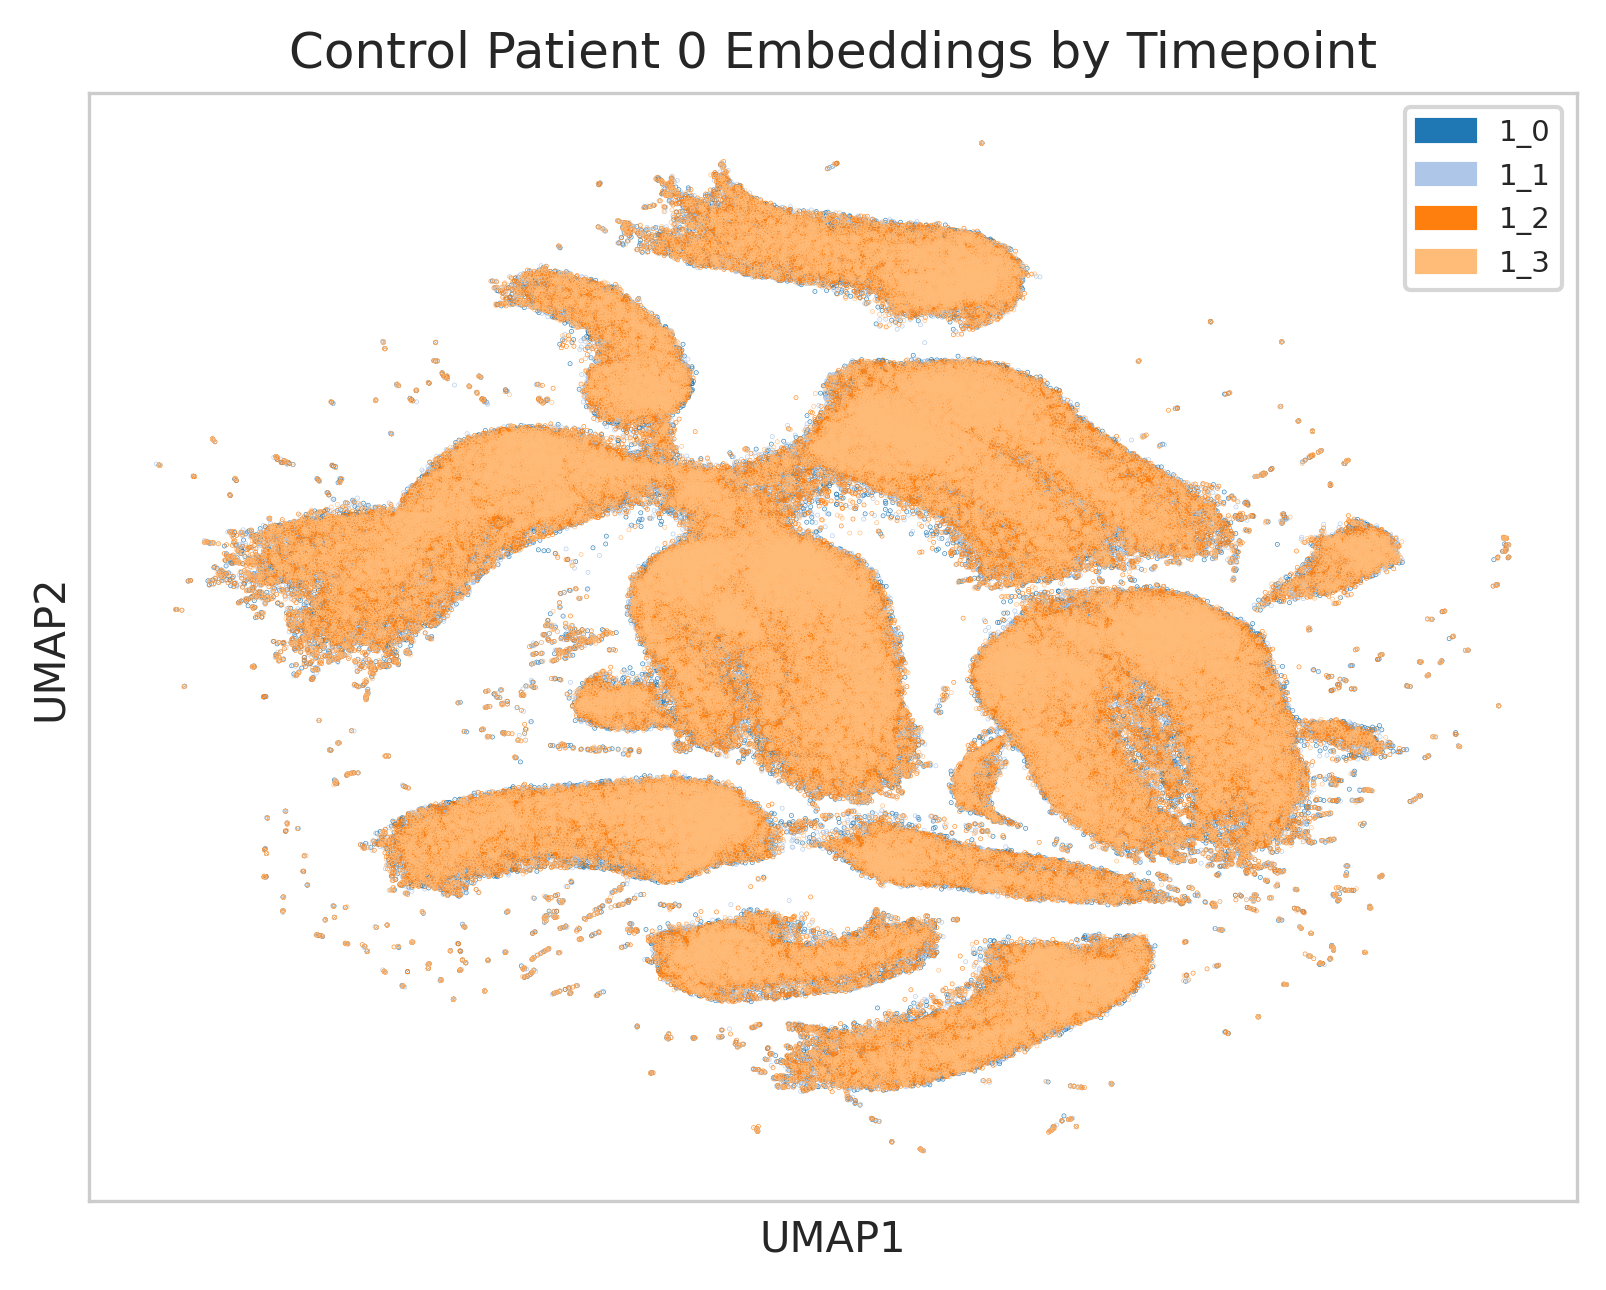

In [74]:
# Control
plot_patient_embeddings(
    sequences_df=control_all_patient_df,
    embeddings=control_all_patient_embeddings,
    color_map=my_color_map,
    patient_type='Control',
    patient_id='0'
)

In [76]:
def plot_combined_embeddings(case_df, case_embeddings, control_df, control_embeddings, color_map):
    """
    Plot the combined embeddings for the first patient from both the "case" and "control" groups.

    Parameters:
    - case_df (pd.DataFrame): The DataFrame containing sequences data for the "case" group.
    - case_embeddings (np.ndarray): The embeddings for the "case" group.
    - control_df (pd.DataFrame): The DataFrame containing sequences data for the "control" group.
    - control_embeddings (np.ndarray): The embeddings for the "control" group.
    - color_map (str): The colormap to use for the plot.

    Returns:
    - None
    """
    # Add a 'group' column to distinguish between "case" and "control"
    case_df['group'] = 'case'
    control_df['group'] = 'control'

    # Concatenate the DataFrames and embeddings
    combined_df = pd.concat([case_df, control_df], ignore_index=True)
    combined_embeddings = np.vstack([case_embeddings, control_embeddings])

    # Initialize the EmbeddingWrapper with the combined DataFrame and embeddings
    embedding_wrapper = EmbeddingWrapper(
        model=None,  # No need for a model if embeddings are already available
        device=None,  # Likewise, no need for a device
        sequences_df=combined_df,
        embeddings=combined_embeddings  # Pass your combined embeddings here
    )

    # Explicitly set the embeddings attribute
    embedding_wrapper.embeddings = combined_embeddings

    # Now, you can use the `plot_embedding` method to plot, setting color to 'group'
    embedding_wrapper.plot_embedding(
        color_embed='group',
        color_map=color_map,
        title='Combined Embeddings by Group'
    )

/home/ubuntu/miniconda3/envs/cvc/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


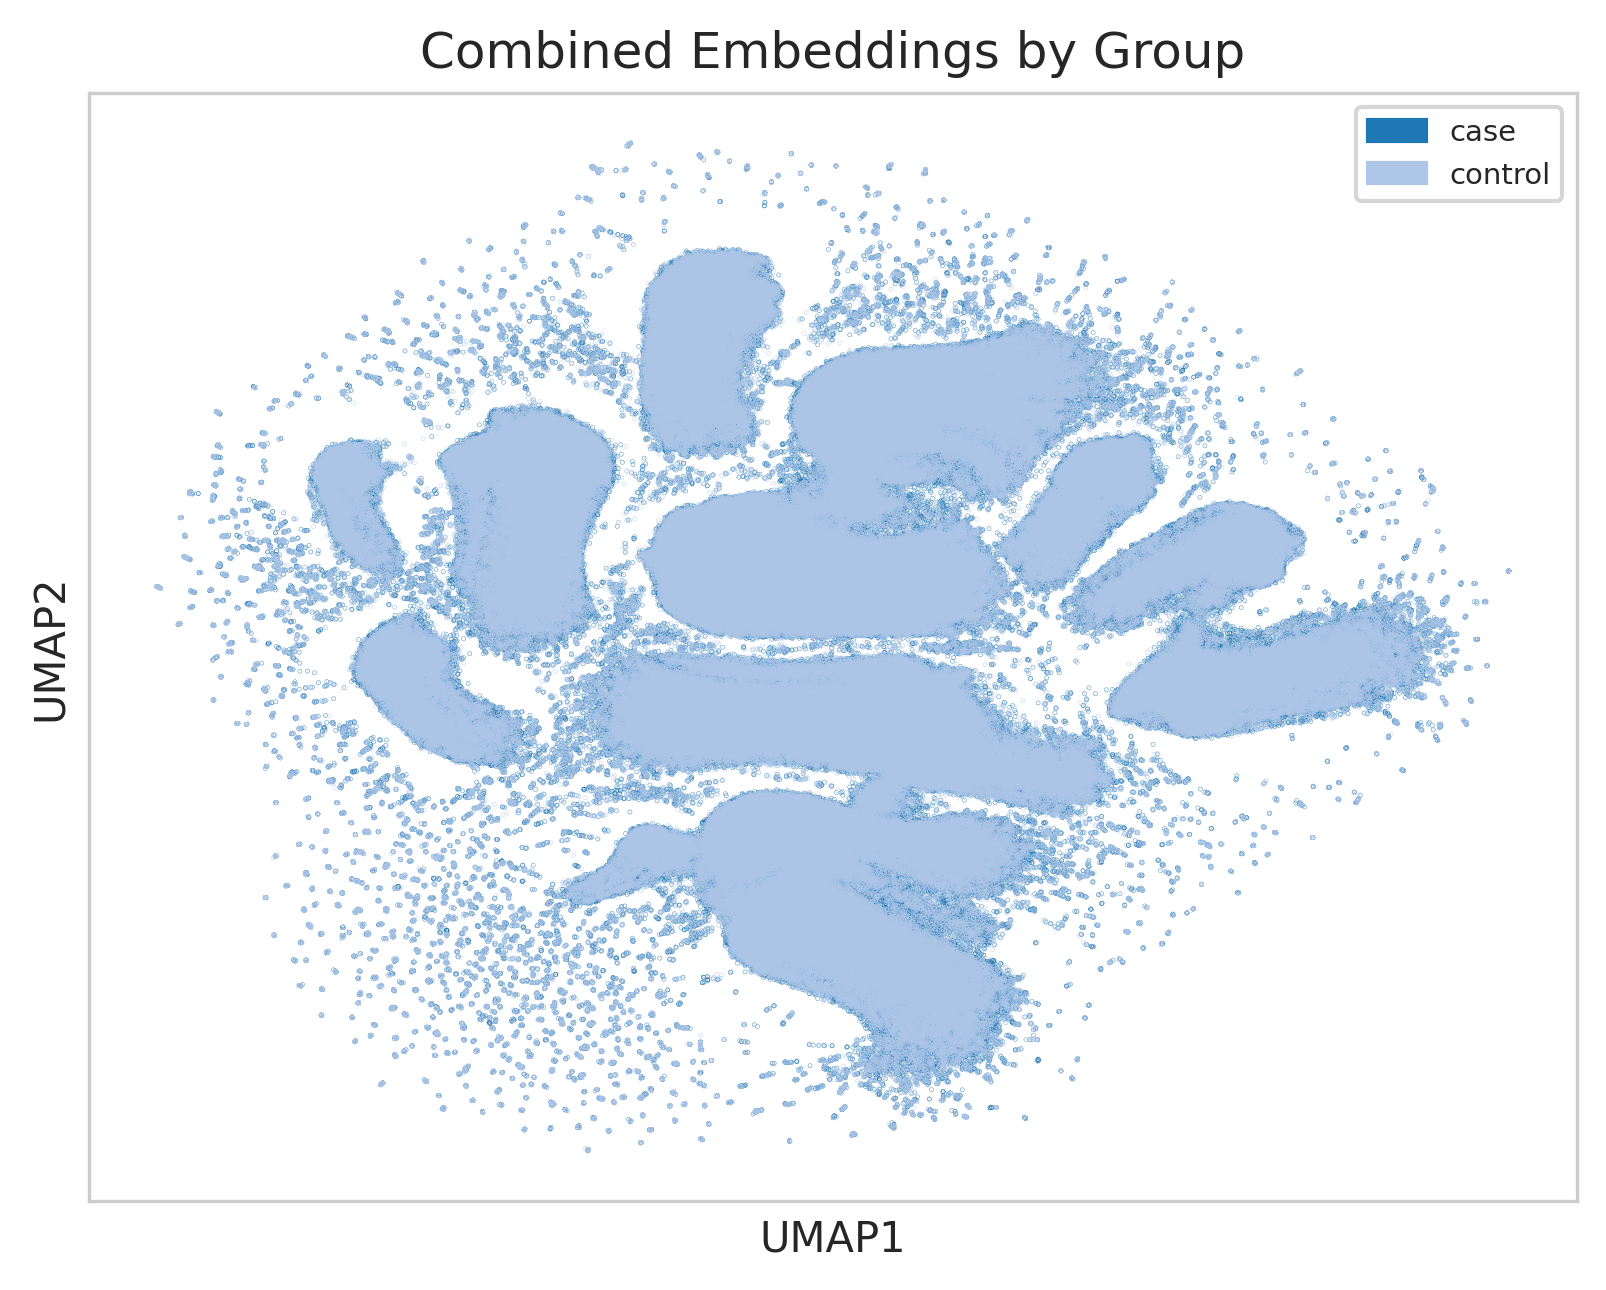

In [78]:
# Sample usage
plot_combined_embeddings(
    case_df=case_all_patient_0_df,  # Replace with your actual DataFrame
    case_embeddings=case_all_patient_0_embeddings,  # Replace with your actual embeddings
    control_df=control_all_patient_0_df,  # Replace with your actual DataFrame
    control_embeddings=control_all_patient_0_embeddings,  # Replace with your actual embeddings
    color_map=my_color_map  # Replace with your actual color map
)

/home/ubuntu/miniconda3/envs/cvc/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


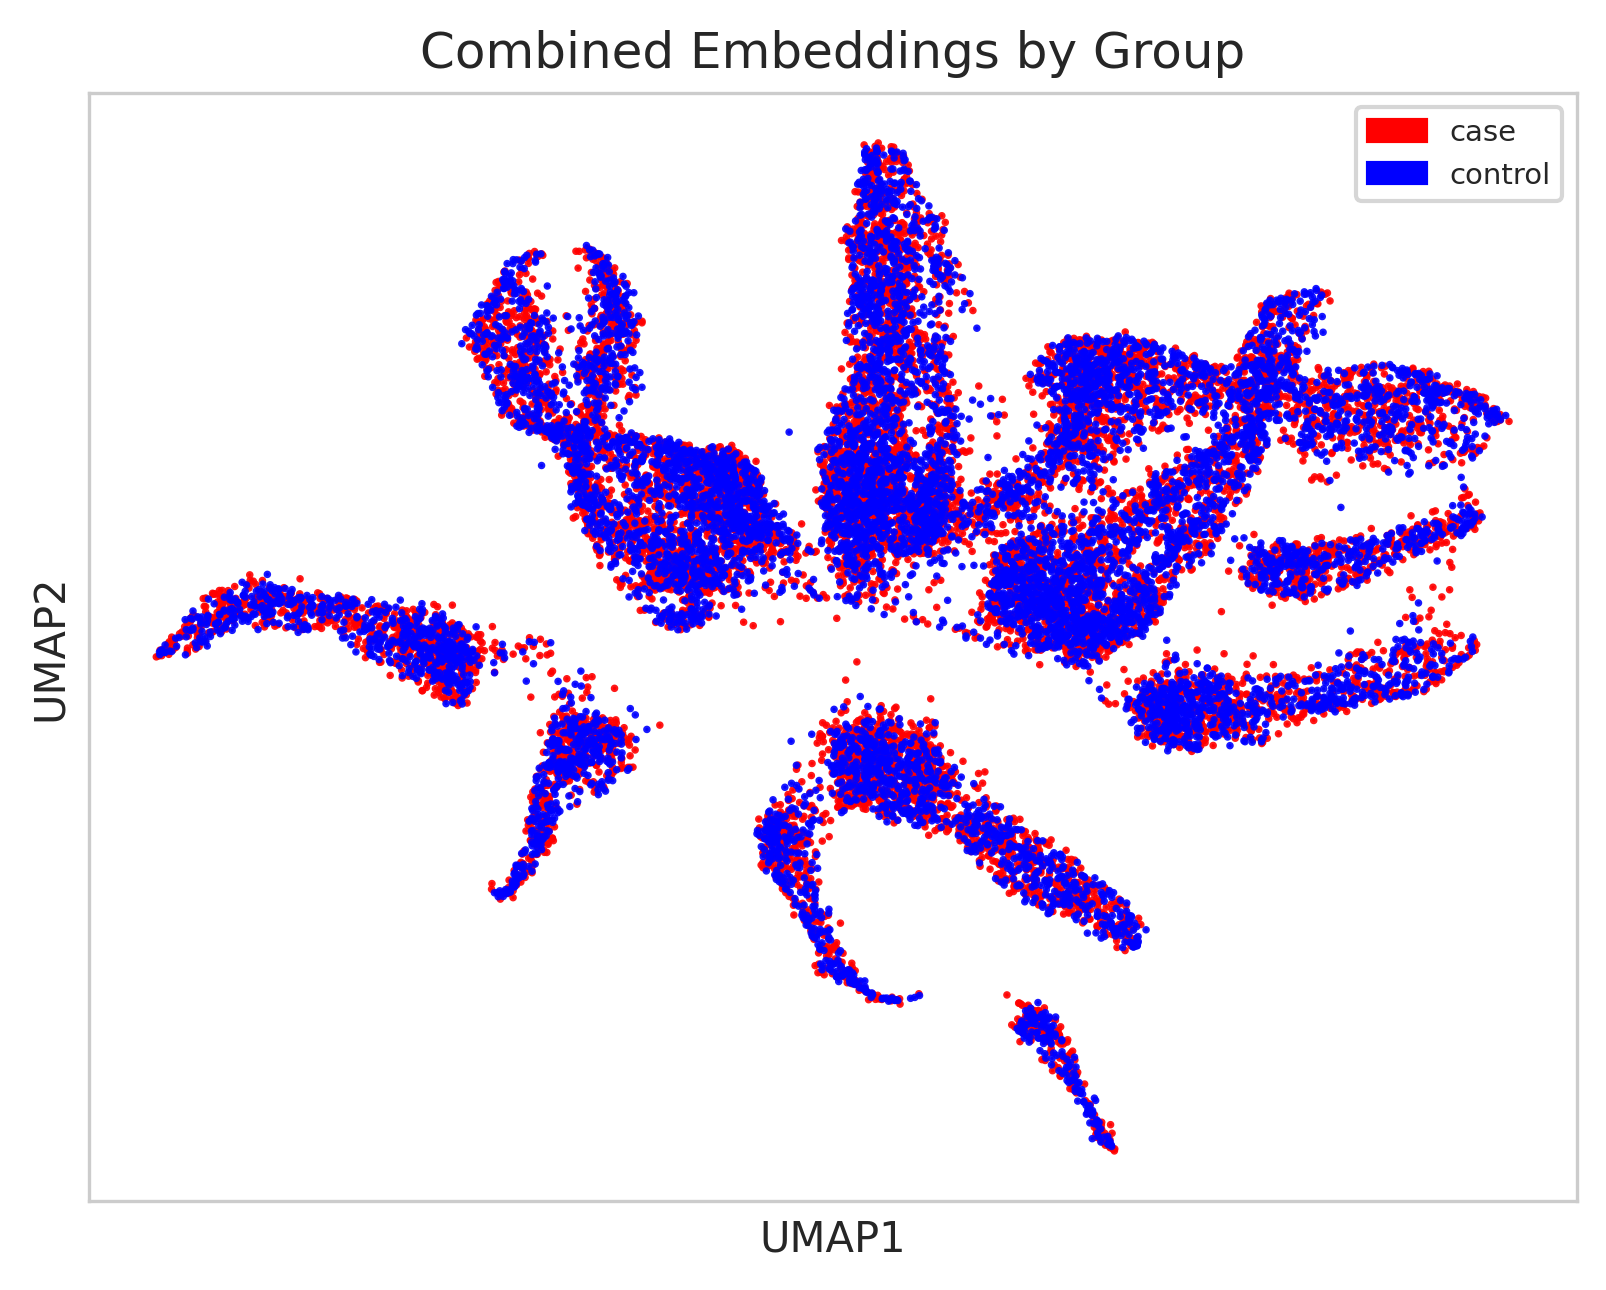

In [88]:
# Sample usage
# plot_combined_embeddings(
#     case_df=case_all_patient_0_df,  # Replace with your actual DataFrame
#     case_embeddings=case_all_patient_0_embeddings,  # Replace with your actual embeddings
#     control_df=control_all_patient_0_df,  # Replace with your actual DataFrame
#     control_embeddings=control_all_patient_0_embeddings,  # Replace with your actual embeddings
#     color_map=my_color_map  # Replace with your actual color map
# )

# take only timepoint 4, labeled as 1_3
case_all_patient_0_df_tp4 = case_all_patient_0_df[case_all_patient_0_df['timepoint'] == '1_3']
control_all_patient_0_df_tp4 = control_all_patient_0_df[control_all_patient_0_df['timepoint'] == '1_3']

# now plot with 10% of the data, and colors red and blue
case_all_patient_0_df_sample = case_all_patient_0_df_tp4.sample(frac=0.1)
control_all_patient_0_df_sample = control_all_patient_0_df_tp4.sample(frac=0.1)
case_all_patient_0_embeddings_sample = case_all_patient_0_embeddings[case_all_patient_0_df_sample.index]
control_all_patient_0_embeddings_sample = control_all_patient_0_embeddings[control_all_patient_0_df_sample.index]
from matplotlib.colors import ListedColormap
my_color_map_sample = ListedColormap(['red', 'blue'])
plot_combined_embeddings(
    case_df=case_all_patient_0_df_sample,  # Replace with your actual DataFrame
    case_embeddings=case_all_patient_0_embeddings_sample,  # Replace with your actual embeddings
    control_df=control_all_patient_0_df_sample,  # Replace with your actual DataFrame
    control_embeddings=control_all_patient_0_embeddings_sample,  # Replace with your actual embeddings
    color_map=my_color_map_sample  # Replace with your actual color map
)

/home/ubuntu/miniconda3/envs/cvc/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_5392/4187372956.py:12: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x, y])


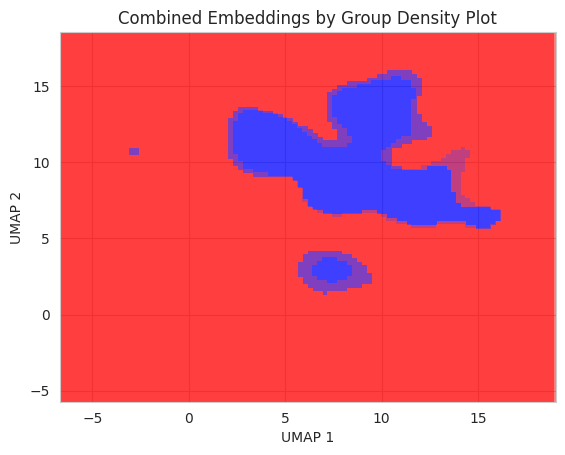

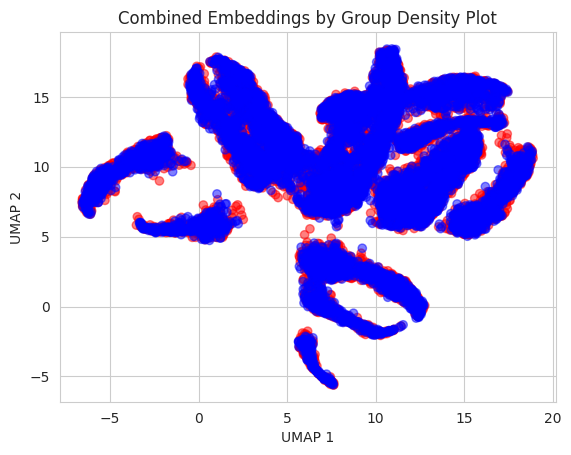

In [92]:
import matplotlib.pyplot as plt
from scipy.stats import kde
import numpy as np

def plot_density(umap_coordinates, labels, color_map, title):
    unique_labels = set(labels)
    cmap_dict = {'case': 'Reds', 'control': 'Blues'}  # Different colormaps for each group

    plt.gca().set_facecolor('grey')  # Setting background color to grey

    for label in unique_labels:
        points = umap_coordinates[np.array(labels) == label]
        x, y = points[:, 0], points[:, 1]

        nbins = 100
        k = kde.gaussian_kde([x, y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))

        plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=cmap_dict[label], alpha=0.5)
    plt.title(title)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()


def plot_combined_embeddings_dense(case_df, case_embeddings, control_df, control_embeddings, color_map):
    case_df['group'] = 'case'
    control_df['group'] = 'control'

    combined_df = pd.concat([case_df, control_df], ignore_index=True)
    combined_embeddings = np.vstack([case_embeddings, control_embeddings])

    embedding_wrapper = EmbeddingWrapper(
        model=None,
        device=None,
        sequences_df=combined_df,
        embeddings=combined_embeddings
    )

    embedding_wrapper.embeddings = combined_embeddings

    # Create AnnData object and run UMAP
    anndata_object = embedding_wrapper.create_anndata(n_comps=50)

    # Extract UMAP coordinates
    umap_coordinates = anndata_object.obsm['X_umap']

    # Extract labels ('case' or 'control')
    labels = combined_df['group'].tolist()

    # Plot density plot
    plot_density(umap_coordinates, labels, color_map, 'Combined Embeddings by Group Density Plot')

plot_combined_embeddings_dense(
        case_df=case_all_patient_0_df_sample,  # Replace with your actual DataFrame
        case_embeddings=case_all_patient_0_embeddings_sample,  # Replace with your actual embeddings
        control_df=control_all_patient_0_df_sample,  # Replace with your actual DataFrame
        control_embeddings=control_all_patient_0_embeddings_sample,  # Replace with your actual embeddings
        color_map=my_color_map_sample  # Replace with your actual color map
)

In [17]:
################################################
# save / load case_data_list and control_data_list
if NEW_DATA == 1:
    # Fit encoders on all graphs
    encoders = gu.fit_encoders_on_all_graphs([case_CVC_graph_dict, control_CVC_graph_dict])
    case_data_list, case_patient_id_list = gu.convert_cvc_graph_to_pyg_data(
        case_CVC_graph_dict, encoders, type='case', label_type='binary')
    control_data_list, control_patient_id_list = gu.convert_cvc_graph_to_pyg_data(
        control_CVC_graph_dict, encoders, type='control', label_type='binary')

    with open(CACHE_DIR + 'case_data_list.pickle', 'wb') as handle:
        pickle.dump(case_data_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(CACHE_DIR + 'case_patient_id_list.pickle', 'wb') as handle:
        pickle.dump(case_patient_id_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(CACHE_DIR + 'control_data_list.pickle', 'wb') as handle:
        pickle.dump(control_data_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(CACHE_DIR + 'control_patient_id_list.pickle', 'wb') as handle:
        pickle.dump(control_patient_id_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(CACHE_DIR + 'case_data_list.pickle', 'rb') as handle:
        case_data_list = pickle.load(handle)
    with open(CACHE_DIR + 'case_patient_id_list.pickle', 'rb') as handle:
        case_patient_id_list = pickle.load(handle)
    with open(CACHE_DIR + 'control_data_list.pickle', 'rb') as handle:
        control_data_list = pickle.load(handle)
    with open(CACHE_DIR + 'control_patient_id_list.pickle', 'rb') as handle:
        control_patient_id_list = pickle.load(handle)

In [18]:
# change the control patient ids to be different from the case patient ids
control_patient_id_list_updated = [int(x) + int(case_patient_id_list[len(case_patient_id_list)-1]) + int(1) for x in control_patient_id_list]
# convert type to string
control_patient_id_list_updated = [str(x) for x in control_patient_id_list_updated]

##### Utils

In [34]:
from sklearn.cluster import KMeans
import umap

def cluster_embeddings(embeddings_dict, n_clusters):
    embeddings = list(embeddings_dict.values())
    labels = list(embeddings_dict.keys())
    umap_embeddings = umap.UMAP().fit_transform(embeddings)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(embeddings)
    cluster_assignments = kmeans.labels_
    return umap_embeddings, labels, cluster_assignments

In [115]:
# Create a scatter plot, color-coded by cluster assignment
def plot_embedding_clustering(umap_embeddings, embeddings_labels, cluster_assignments):
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_assignments, cmap='Spectral', s=5)

    # Label points by patient_timepoint
    for label, (x, y), cluster in zip(embeddings_labels, umap_embeddings, cluster_assignments):
        plt.annotate(f"{label}", (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the cases, color-coded by cluster assignment', fontsize=16)
    plt.show()

In [81]:
# create a function that calculates the cluster composition
def calculate_cluster_composition(cluster_labels_dict):
    # Initialize an empty dictionary for cluster compositions
    cluster_compositions = {}
    # Iterate over the clusters dictionary
    for key, cluster in cluster_labels_dict.items():
        # Split the key into type (case or control) and the original key
        type, original_key = key.split(":")
        # If the cluster is not already in the cluster_compositions dictionary, add it
        if cluster not in cluster_compositions:
            cluster_compositions[cluster] = {"case": 0, "control": 0}
        # Increase the count for the type in the corresponding cluster
        cluster_compositions[cluster][type] += 1
    # Print out the composition of each cluster
    for cluster, composition in cluster_compositions.items():
        # calculate percent
        total = sum(composition.values())
        for key, value in composition.items():
            composition[key] = round(value / total * 100, 2)
    return cluster_compositions

##### Cluster Analysis - Cases

In [52]:
case_umap_embeddings, case_embeddings_labels, case_cluster_assignments = cluster_embeddings(case_graph_embeddings_dict, 2)

/home/dsi/rgoldner/anaconda3/envs/cvc_env_py3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


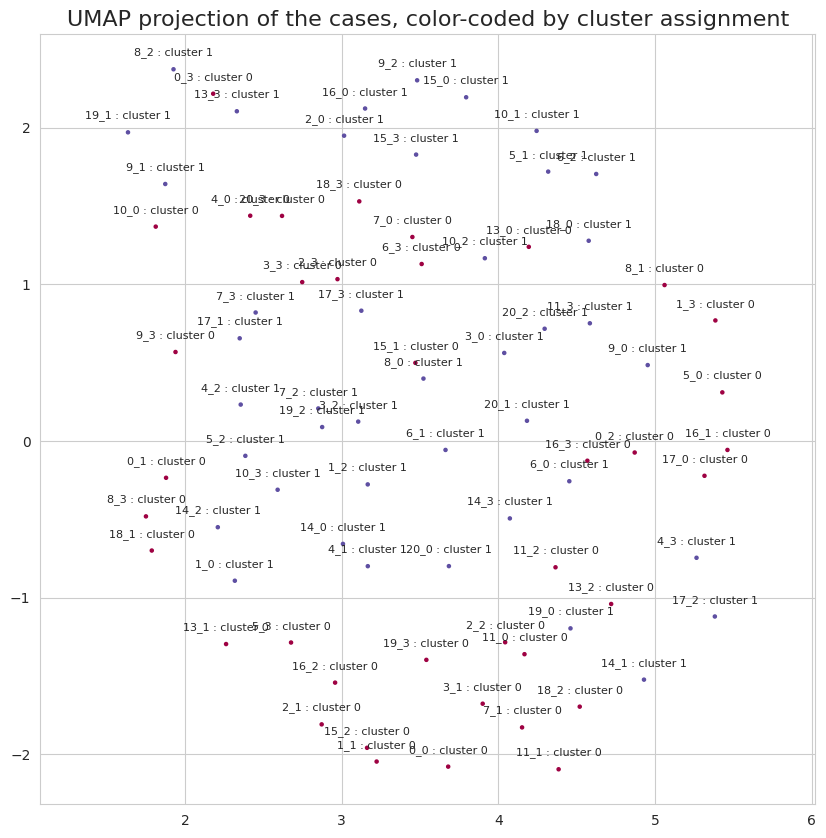

In [53]:
plot_embedding_clustering(case_umap_embeddings, case_embeddings_labels, case_cluster_assignments)

##### Cluster Analysis - Cases and Controls

In [38]:
# combine the case and control dictionaries
case_embeddings_dict = {f'case:{k}': v for k, v in case_graph_embeddings_dict.items()}
control_embeddings_dict = {f'control:{k}': v for k, v in control_graph_embeddings_dict.items()}

combined_case_control_dict = {**case_embeddings_dict, **control_embeddings_dict}

In [112]:
# retrieve the embeddings, labels and cluster assignments
all_umap_embeddings, all_labels, all_cluster_assignments = cluster_embeddings(combined_case_control_dict, 7)
# create dictionary of cluster labels with cluster assignments
all_cluster_labels_dict = {f'{k}': v for k, v in zip(all_labels, all_cluster_assignments)}

/home/dsi/rgoldner/anaconda3/envs/cvc_env_py3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


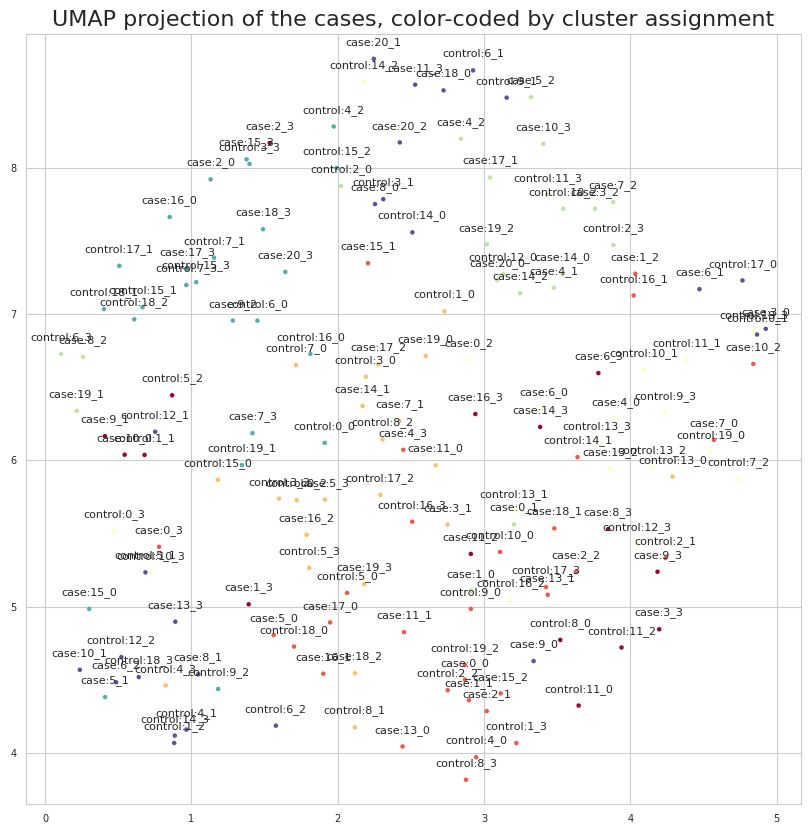

In [116]:
plot_embedding_clustering(all_umap_embeddings, all_labels, all_cluster_assignments)

In [114]:
# calculate the cluster composition|
all_cluster_compositions = calculate_cluster_composition(all_cluster_labels_dict)
all_cluster_compositions

{1: {'case': 56.25, 'control': 43.75},
 4: {'case': 71.43, 'control': 28.57},
 3: {'case': 22.22, 'control': 77.78},
 0: {'case': 68.75, 'control': 31.25},
 5: {'case': 40.0, 'control': 60.0},
 6: {'case': 46.15, 'control': 53.85},
 2: {'case': 45.45, 'control': 54.55}}

In [90]:
# create a function that calculates the cluster composition for cases and controls for different k values
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
def calculate_cluster_composition_for_k_values(embeddings_dict, k_values):
    # create an empty dictionary for the cluster compositions
    cluster_compositions_dict = {}
    # iterate over the k values
    for k in k_values:
        # cluster the embeddings
        umap_embeddings, embeddings_labels, cluster_assignments = cluster_embeddings(embeddings_dict, k)
        # create dictionary of cluster labels with cluster assignments
        cluster_labels_dict = {f'{k}': v for k, v in zip(embeddings_labels, cluster_assignments)}
        # calculate the cluster composition
        cluster_compositions = calculate_cluster_composition(cluster_labels_dict)
        # add the cluster composition to the dictionary
        cluster_compositions_dict[k] = cluster_compositions
    return cluster_compositions_dict

# plot the cluster composition for cases and controls for different k values
def plot_cluster_composition_for_k_values(cluster_compositions_dict):
    # create a dataframe from the cluster compositions dictionary
    cluster_compositions_df = pd.DataFrame.from_dict({(i,j): cluster_compositions_dict[i][j]
                           for i in cluster_compositions_dict.keys()
                           for j in cluster_compositions_dict[i].keys()},
                       orient='index')
    # plot the dataframe
    cluster_compositions_df.plot(kind='bar', figsize=(15, 10))
    plt.xlabel('K value')
    plt.ylabel('Cluster Composition')
    plt.title('Cluster Composition for Cases and Controls for Different K Values')
    plt.show()

/home/dsi/rgoldner/anaconda3/envs/cvc_env_py3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/dsi/rgoldner/anaconda3/envs/cvc_env_py3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/dsi/rgoldner/anaconda3/envs/cvc_env_py3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/dsi/rgoldner/anaconda3/envs/cvc_env_py3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Se

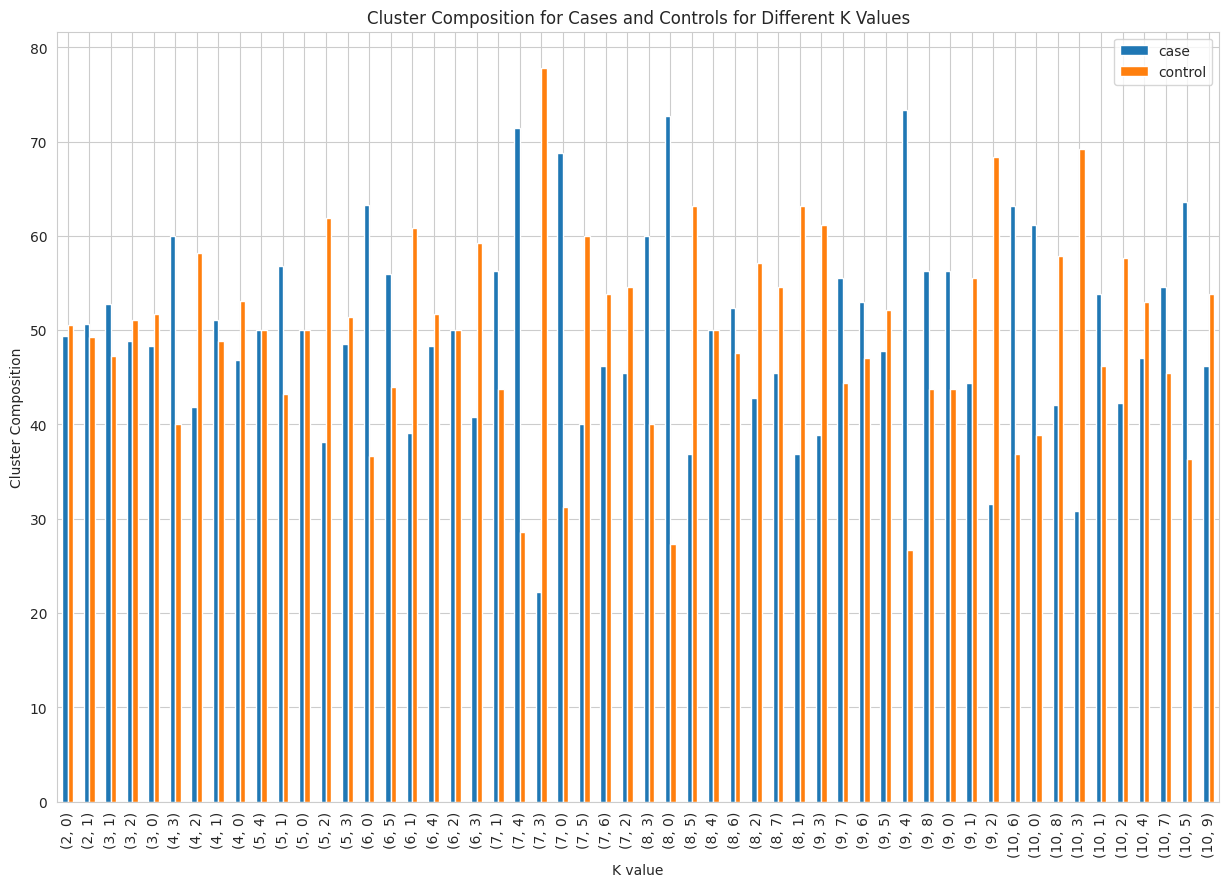

In [91]:
# calculate the cluster composition for cases and controls for different k values
cluster_compositions_dict = calculate_cluster_composition_for_k_values(combined_case_control_dict, k_values)
# plot the cluster composition for cases and controls for different k values
plot_cluster_composition_for_k_values(cluster_compositions_dict)

### Analyze the Unique Sequences in the Patients

In [98]:
# extract the unique sequences for each patient
def get_unique_seqs_per_patient(dataframes_dict):
    unique_sequences_dict = {}
    for patient_id, dfs in dataframes_dict.items():
        for i, df in enumerate(dfs):
            # create a unique label for each patient timepoint
            patient_timepoint = f"{patient_id}_{i}"
            # get the sequences column
            sequences = df['Sequences']
            # get the unique sequences
            unique_sequences = set(sequences)
            # add the unique sequences to the dictionary
            unique_sequences_dict[patient_timepoint] = unique_sequences
    return unique_sequences_dict

# extract the private sequences for each patient
def private_seqs_per_patient_timepoint(unique_seqs_dic):
    unique_to_patient_timepoint = {}
    # iterate over each patient timepoint
    for pt1 in unique_seqs_dic.keys():
        # get the sequences for this patient timepoint
        sequences_pt1 = unique_seqs_dic[pt1]
        # get the sequences for all other patient timepoints
        sequences_other_pts = set().union(*[unique_seqs_dic[pt2] for pt2 in unique_seqs_dic.keys() if pt2 != pt1])
        # find sequences that are in pt1 but not in the others
        unique_sequences_pt1 = sequences_pt1 - sequences_other_pts
        # add the unique sequences to the new dictionary
        unique_to_patient_timepoint[pt1] = unique_sequences_pt1
    return unique_to_patient_timepoint

In [99]:
cases_unique_sequences_dict = get_unique_seqs_per_patient(cases_dataframes_dict)
cases_private_sequences_dict = private_seqs_per_patient_timepoint(cases_unique_sequences_dict)

controls_unique_sequences_dict = get_unique_seqs_per_patient(control_dataframes_dict)
controls_private_sequences_dict = private_seqs_per_patient_timepoint(controls_unique_sequences_dict)

In [100]:
def plot_sequences(sequence_dict, title):
    # extract patient_ids and timepoints from keys
    patient_ids = [key.split('_')[0] for key in sequence_dict.keys()]
    timepoints = [key.split('_')[1] for key in sequence_dict.keys()]

    # get counts of sequences
    sequence_counts = [len(seqs) for seqs in sequence_dict.values()]

    # Create a DataFrame
    df = pd.DataFrame({
        'Patient': patient_ids,
        'Timepoint': timepoints,
        'Sequences': sequence_counts
    })

    # convert Timepoint to categorical type for proper ordering
    df['Timepoint'] = pd.Categorical(df['Timepoint'], categories=['0','1','2','3'], ordered=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Patient', y='Sequences', hue='Timepoint', palette='Set3')

    plt.xlabel('Patient')
    plt.ylabel('Number of Sequences')
    plt.title(title)
    plt.legend(title='Timepoint')

    plt.show()

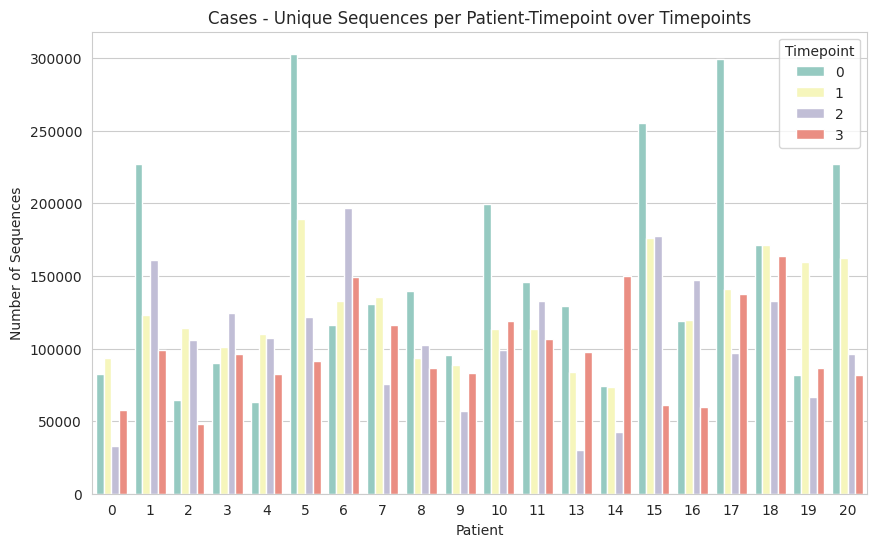

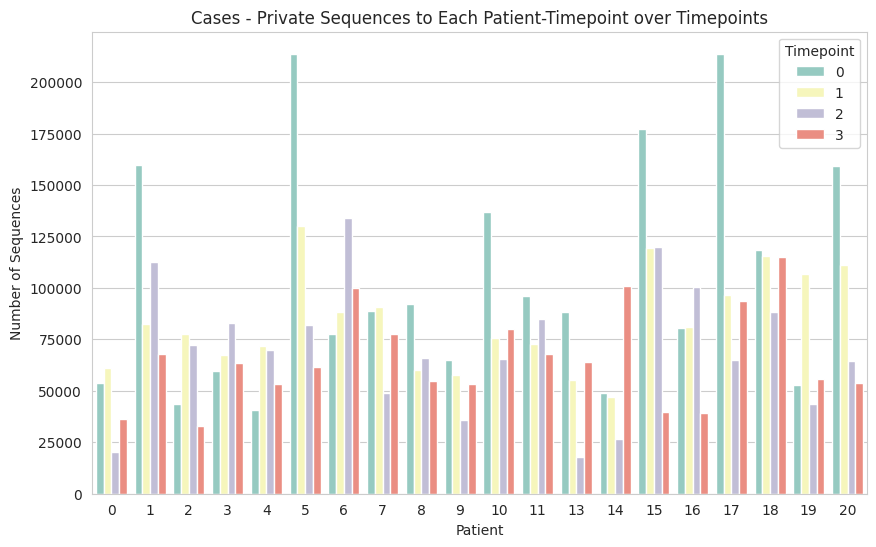

In [101]:
plot_sequences(cases_unique_sequences_dict, 'Cases - Unique Sequences per Patient-Timepoint over Timepoints')
plot_sequences(cases_private_sequences_dict, 'Cases - Private Sequences to Each Patient-Timepoint over Timepoints')

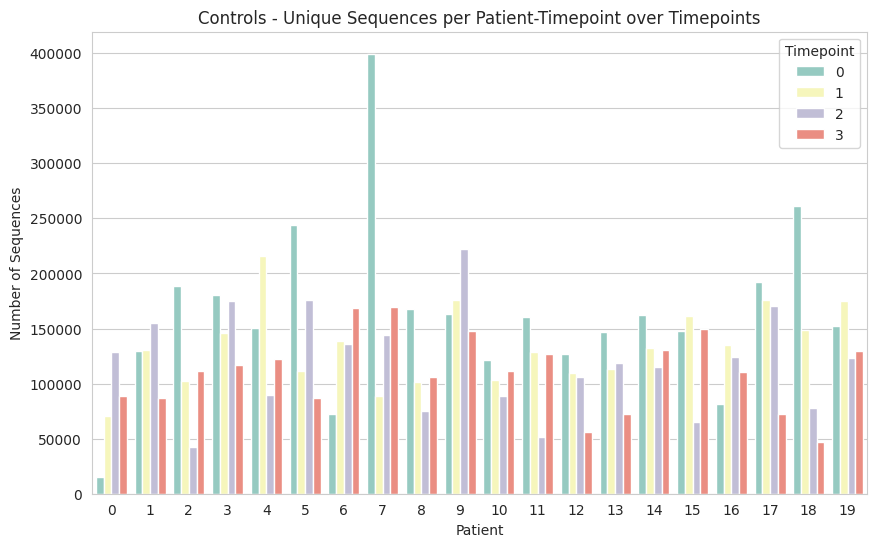

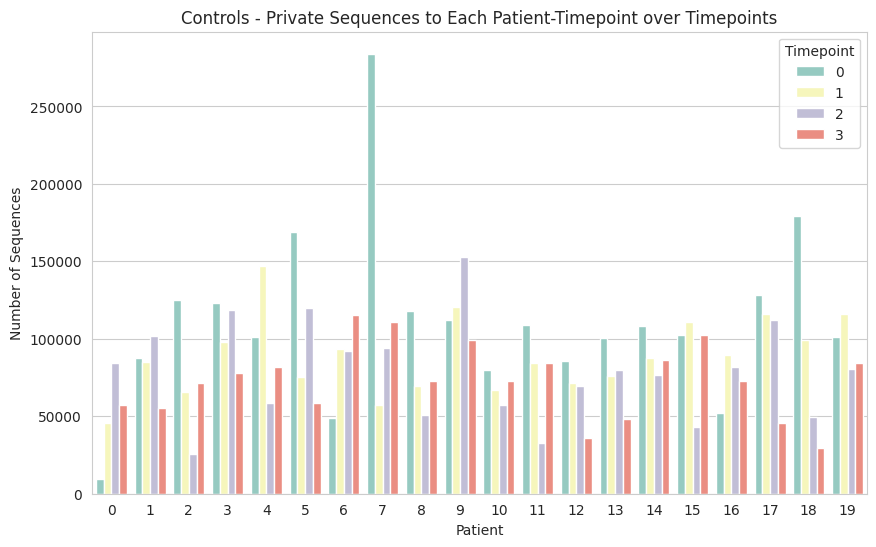

In [102]:
plot_sequences(controls_unique_sequences_dict, 'Controls - Unique Sequences per Patient-Timepoint over Timepoints')
plot_sequences(controls_private_sequences_dict, 'Controls - Private Sequences to Each Patient-Timepoint over Timepoints')

In [103]:
def compare_dicts(unique_dict, private_dict):
    comparison_dict = {}
    for key in unique_dict.keys():
        total_unique = len(unique_dict[key])
        total_private = len(private_dict.get(key, []))
        private_ratio = total_private / total_unique if total_unique > 0 else 0
        comparison_dict[key] = {"Total Count": total_unique,
                                "Private Count": total_private,
                                "Private to Total Ratio": private_ratio}
    return comparison_dict

cases_comparison_dict = compare_dicts(cases_unique_sequences_dict, cases_private_sequences_dict)

In [104]:
def plot_sequence_comparison(comparison_df, group_name):
    # Create a new figure and set its size
    plt.figure(figsize=(10, 6))
    # Create an array with the positions of each bar along the x-axis
    x = range(len(comparison_df))
    # Plot total unique sequences
    plt.bar(x, comparison_df['Total Count'], width=0.4, align='center', color='b', label='Total Unique')
    # Plot total private sequences
    plt.bar(x, comparison_df['Private Count'], width=0.4, align='edge', color='r', label='Total Private')
    # Plot the ratio of private to unique sequences
    plt.plot(x, comparison_df['Private to Total Ratio'], color='g', marker='o', linestyle='-', label='Private/Unique Ratio')
    # Add labels to the x-axis with the patient-timepoint names
    plt.xticks(ticks=x, labels=comparison_df.index, rotation=45)
    # Add a legend
    plt.legend()
    # Add a title and labels to the x and y axes
    plt.title(f'Comparison of Unique and Private Sequences for {group_name}')
    plt.xlabel('Patient-Timepoint')
    plt.ylabel('Number of Sequences')
    # Add percentages above the bars
    for i, count in enumerate(comparison_df['Total Count']):
        # Calculate the percentage and position of the text
        pct = comparison_df['Private to Total Ratio'][i]
        x_text = x[i] - 0.1
        y_text = count + 0.1
        # Add the text to the plot
        plt.text(x_text, y_text, f'{pct:.1%}', color='g')
        # make text smaller
        plt.rcParams.update({'font.size': 7})
    # Show the plot
    plt.tight_layout()
    plt.show()

In [105]:
# compare the unique and private sequences for each patient-timepoint
cases_timepoint_comparison_dict = compare_dicts(cases_unique_sequences_dict, cases_private_sequences_dict)
controls_timepoint_comparison_dict = compare_dicts(controls_unique_sequences_dict, controls_private_sequences_dict)

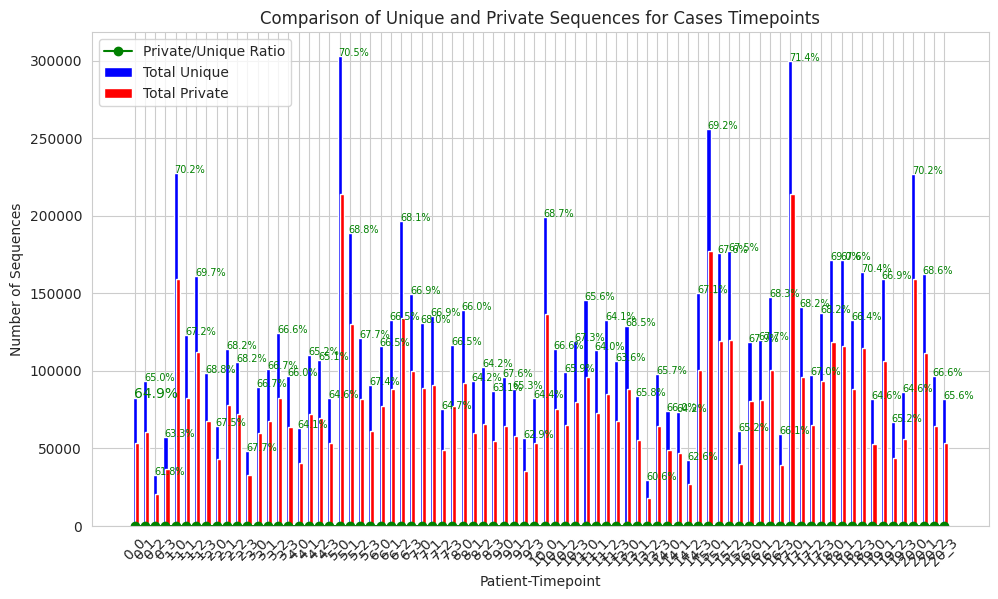

In [106]:
plot_sequence_comparison(pd.DataFrame(cases_timepoint_comparison_dict).T, 'Cases Timepoints')

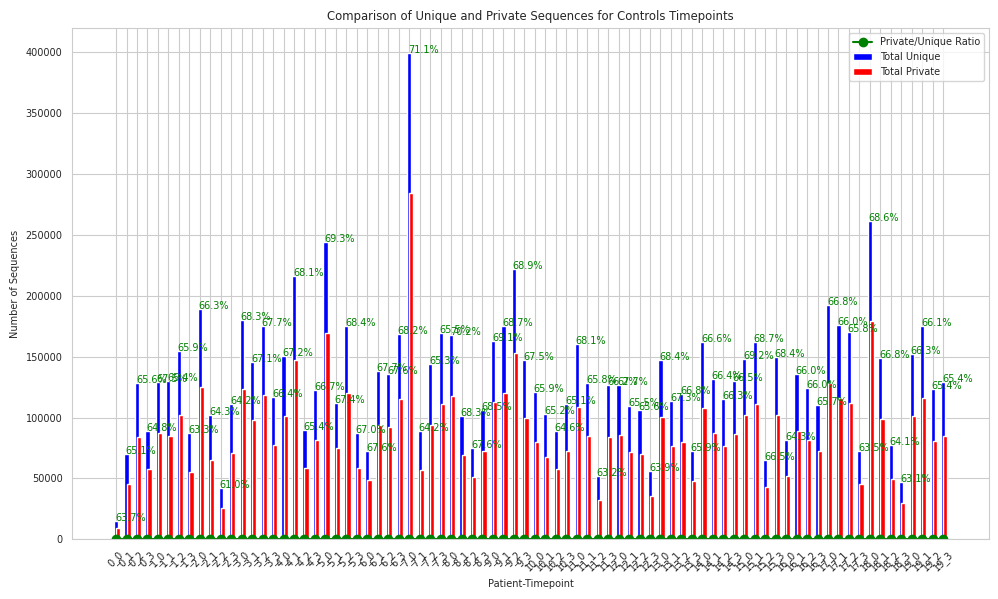

In [107]:
plot_sequence_comparison(pd.DataFrame(controls_timepoint_comparison_dict).T, 'Controls Timepoints')

In [108]:
def get_unique_seqs_per_patient_general(dataframes_dict):
    unique_sequences_dict = {}
    for patient_id, dfs in dataframes_dict.items():
        all_sequences = []
        for df in dfs:
            # get the sequences column
            sequences = df['Sequences']
            all_sequences.extend(sequences)
        # get the unique sequences
        unique_sequences = set(all_sequences)
        # add the unique sequences to the dictionary
        unique_sequences_dict[patient_id] = unique_sequences
    return unique_sequences_dict

def private_seqs_per_patient_general(unique_seqs_dic):
    unique_to_patient = {}
    # iterate over each patient
    for pt1 in unique_seqs_dic.keys():
        # get the sequences for this patient
        sequences_pt1 = unique_seqs_dic[pt1]
        # get the sequences for all other patients
        sequences_other_pts = set().union(*[unique_seqs_dic[pt2] for pt2 in unique_seqs_dic.keys() if pt2 != pt1])
        # find sequences that are in pt1 but not in the others
        unique_sequences_pt1 = sequences_pt1 - sequences_other_pts
        # add the unique sequences to the new dictionary
        unique_to_patient[pt1] = unique_sequences_pt1
    return unique_to_patient

In [109]:
cases_patient_all_seqs_dict = get_unique_seqs_per_patient_general(cases_dataframes_dict)
cases_patient_private_seqs_dict = private_seqs_per_patient_general(cases_patient_all_seqs_dict)

control_patient_all_seqs_dict = get_unique_seqs_per_patient_general(control_dataframes_dict)
control_patient_private_seqs_dict = private_seqs_per_patient_general(control_patient_all_seqs_dict)

In [110]:
cases_patient_comparison_dict = compare_dicts(cases_patient_all_seqs_dict, cases_patient_private_seqs_dict)
control_patient_comparison_dict = compare_dicts(control_patient_all_seqs_dict, control_patient_private_seqs_dict)

In [ ]:
plot_sequence_comparison(pd.DataFrame(cases_patient_comparison_dict).T, 'Cases Patients')

In [ ]:
plot_sequence_comparison(pd.DataFrame(control_patient_comparison_dict).T, 'Controls Patients')